['Version: 2,mlflow-artifacts:/0/9c4191d3dbd84b59a37d5ecce9a48cf4/artifacts/final_model.joblib', 'Version: 1,mlflow-artifacts:/0/9016ad5724b64ad79c16f1608393b39b/artifacts/final_model.joblib']
Path to model: mlartifacts/0/9c4191d3dbd84b59a37d5ecce9a48cf4/artifacts/final_model.joblib


/tmp/ipykernel_14428/3234966309.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["Accepted", "Failure"], y=predicted_probs, palette=colors)


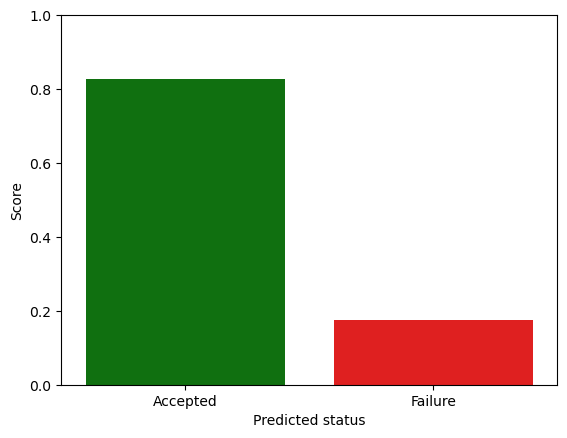

2024/09/29 14:38:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run fearless-robin-869 at: http://localhost:5000/#/experiments/0/runs/1183b1bd0c834c24bc98ac9a28ac74ea.
2024/09/29 14:38:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.


Model run and artifacts logged in MLflow


In [154]:
import mlflow
import mlflow.pyfunc
from mlflow import MlflowClient
import pandas as pd
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Load the input data
data_tests_app = pd.read_csv("data_prod.csv", index_col=0).drop("TARGET", axis=1)
INPUT_EXAMPLE = pd.DataFrame(data_tests_app.iloc[0]).T

# Define the model name
best_model_name = "LogisticRegression_F10"

# Connect to MLflow server
mlflow.set_tracking_uri("http://localhost:5000")
client = mlflow.tracking.MlflowClient()

# Fetch all registered versions of the model
registered_models = client.search_model_versions(f"name='{best_model_name}'")
list_versions = []
for model in registered_models:
    list_versions.append(f"Version: {model.version},{model.source}")
print(list_versions)
# Get the model path
version = list_versions[0].split(",")[0]
path_model = list_versions[0].split(",")[1].replace("mlflow-artifacts:", "mlartifacts")
print("Path to model:",path_model)
loaded_model = joblib.load(path_model)

# Log the model version to MLflow
with mlflow.start_run() as run:
    mlflow.log_param("model_version", version)
    
    # Predict and log outputs
    default_class = loaded_model.predict(INPUT_EXAMPLE)[0]
    probas = loaded_model.predict_proba(INPUT_EXAMPLE)[0]
    mlflow.log_metric("Default predicted class", int(default_class))
    mlflow.log_metric("Negative class membership", probas[0])
    mlflow.log_metric("Positive class membership", probas[1])
    
    # Create the barplot
    predicted_probs = loaded_model.predict_proba(INPUT_EXAMPLE)[0]
    colors = ["green", "red"]
    sns.barplot(x=["Accepted", "Failure"], y=predicted_probs, palette=colors)
    plt.ylim(0, 1)
    plt.xlabel("Predicted status")
    plt.ylabel("Score")
    
    # Save the plot to a file and log it to MLflow
    plot_path = "barplot_prediction.png"
    plt.savefig(plot_path)
    mlflow.log_artifact(plot_path)
    plt.show()

# Optionally, register or load the model using MLflow
# mlflow.pyfunc.log_model("logreg_model", artifact_path="models", python_model=loaded_model)

print("Model run and artifacts logged in MLflow")